# 第2题

## 初始化

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve, norm

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体（适用于中文）
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
plt.style.use('fivethirtyeight')  # 设置绘图风格
np.random.seed(0)


# 设置随机种子与问题规模
np.random.seed(0)
n, p = 500, 100
A = np.random.randn(p, n)
x0 = np.random.randn(n)
b = A @ x0  # 保证 x0 是可行解

# 目标函数和导数
def f(x):
    max_x = np.max(x)  # 找到 x 的最大值
    return np.log(np.sum(np.exp(x - max_x)) + 1e-10) + max_x

def grad_f(x):
    e = np.exp(x)
    return e / np.sum(e + 1e-10)

def hess_f(x):
    pvec = grad_f(x)
    return np.diag(pvec) - np.outer(pvec, pvec)


In [195]:
# 投影矩阵 P = I - A^T(AA^T)^{-1}A
P = np.eye(n) - A.T @ solve(A @ A.T, A)

# 方法1：投影梯度法
def projected_gradient(x_init, K=200, alpha=0.3, beta=0.5, epsilon=1e-4):
    x = x_init.copy()
    fs = []
    xs = [x]
    for _ in range(K):
        g = grad_f(x)
        d = -P @ g
        t = 1.0
        while f(x + t * d) > f(x) + alpha * t * g.dot(d):
            t *= beta
        x = x + t * d
        fs.append(f(x))
        xs.append(x)
        if norm(x - xs[-2], 1) <= epsilon:
            break
    return x, fs, xs

In [196]:
# 方法2：带回溯的 Newton 方法
def damped_newton(x_init, K=200, alpha=0.3, beta=0.5, epsilon=1e-4):
    x = x_init.copy()
    fs = []
    xs = [x]
    for _ in range(K):
        g = grad_f(x)
        H = hess_f(x)
        top = np.hstack([H, A.T])
        bottom = np.hstack([A, np.zeros((p, p))])
        M = np.vstack([top, bottom])
        rhs = -np.concatenate([g, np.zeros(p)])
        sol = solve(M, rhs)
        dx = sol[:n]
        t = 1.0
        while f(x + t * dx) > f(x) + alpha * t * g.dot(dx):
            t *= beta
        lambdax = np.dot(dx.T, np.dot(H, dx))
        x = x + t * dx
        fs.append(f(x))
        xs.append(x)
        if lambdax <= 2 * epsilon:
            break
    return x, fs, xs

In [197]:
import numpy as np
from numpy.linalg import solve

# 定义目标函数 g(v)
def g(v):
    s = -A.T @ v
    return np.sum(s * np.log(s + 1e-10)) - v @ b

# 定义梯度 grad_g(v)
def grad_g(v):
    return A @ (np.log(-A.T @ v + 1e-10) + 1) - b

# 定义 Hessian hess_g(v)
def hess_g(v):
    s = -A.T @ v
    return A @ np.diag(1 / s) @ A.T

# 阻尼牛顿法求解对偶问题
def damped_newton_dual(v_init, K=200, alpha=0.3, beta=0.5, epsilon=1e-4):
    p, n = A.shape
    v = v_init.copy()
    fs = []  # 存储目标函数值
    vs = [v.copy()]  # 存储变量的历史值

    for _ in range(K):
        # 计算目标函数值
        fs.append(g(v))
        
        # 计算梯度和 Hessian
        grad = grad_g(v)
        H = hess_g(v)

        # 构造线性方程组 M @ sol = rhs
        top = np.hstack([H, A])
        bottom = np.hstack([A.T, np.zeros((n, n))])
        M = np.vstack([top, bottom])
        rhs = -np.concatenate([grad, np.zeros(n)])

        # 求解线性方程组，计算更新方向 dv
        try:
            sol = solve(M, rhs)
        except np.linalg.LinAlgError:
            sol = np.linalg.lstsq(M, rhs, rcond=None)[0]
        dv = sol[:p]  # 更新方向

        # 回溯线搜索确定步长 t
        t = 1.0
        while True:
            v_new = v + t * dv
            s_new = -A.T @ v_new  # 计算新的 s
            if np.all(s_new > 0):  # 确保 s_new 全部为正
                if g(v_new) <= g(v) + alpha * t * grad.dot(dv):  # 检查 Armijo 条件
                    break
            t *= beta  # 缩小步长
            if t < 1e-10:  # 如果步长过小，退出循环
                break

        # 更新变量 v
        lambdax = np.dot(dv.T, np.dot(H, dv))  # 检查收敛条件
        v = v + t * dv
        fs.append(g(v))
        vs.append(v)
        if lambdax <= 2 * epsilon:  # 收敛条件
            break

    return v, fs, vs

In [198]:
# 用高精度 Newton 方法估计最优值 f*
_, fs_ref, _ = damped_newton(x0, K=10000)
f_star = fs_ref[-1]
f_star

-26.933585132500074

In [201]:
# 运行三种方法
K = 500000
_, fs_proj, _ = projected_gradient(x0, K)
_, fs_dn, _  = damped_newton(x0, K)
u0 = np.ones(p) / p
_, fs_dual, _ = damped_newton_dual(u0)

C:\Users\sillybear\AppData\Local\Temp\ipykernel_28928\3595955155.py:7: RuntimeWarning: invalid value encountered in log
  return np.sum(s * np.log(s + 1e-10)) - v @ b
C:\Users\sillybear\AppData\Local\Temp\ipykernel_28928\3595955155.py:11: RuntimeWarning: invalid value encountered in log
  return A @ (np.log(-A.T @ v + 1e-10) + 1) - b


C:\Users\sillybear\AppData\Local\Temp\ipykernel_28928\2296667141.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.array(fs_dn) - f_star), label='Damped Newton')


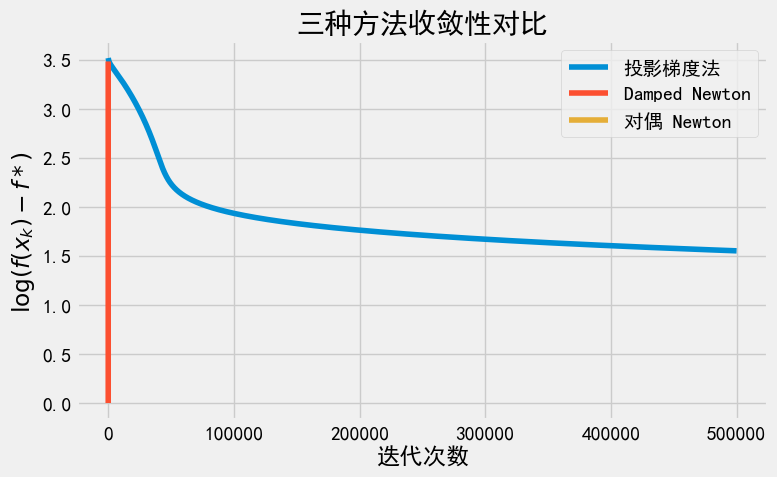

In [202]:
# 绘制 log(f(x_k)-f*) 曲线
plt.figure(figsize=(8, 5))
plt.plot(np.log(np.array(fs_proj) - f_star), label='投影梯度法')
plt.plot(np.log(np.array(fs_dn) - f_star), label='Damped Newton')
plt.plot(np.log(np.array(fs_dual) - f_star), label='对偶 Newton')
plt.xlabel('迭代次数')
plt.ylabel(r'$\log(f(x_k) - f*)$')
plt.title('三种方法收敛性对比')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 第3题

C:\Users\sillybear\AppData\Local\Temp\ipykernel_28928\4201031960.py:52: RuntimeWarning: divide by zero encountered in log
  log_f_xk_minus_f_star_abs = np.log(np.array(function_values_abs) - f_star_abs)
C:\Users\sillybear\AppData\Local\Temp\ipykernel_28928\4201031960.py:53: RuntimeWarning: divide by zero encountered in log
  log_f_xk_minus_f_star_courant = np.log(np.array(function_values_courant) - f_star_courant)


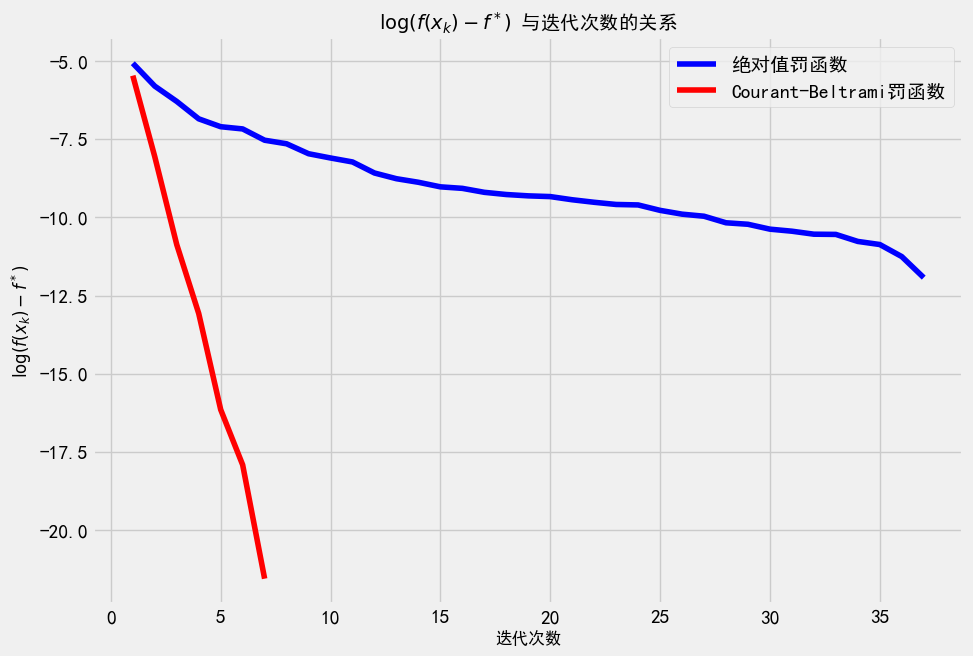

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 随机生成 A 和 b
m, n = 200, 300
A = np.random.randn(m, n)
b = np.random.randn(m)

# 绝对值罚函数方法
def abs_penalty_function(x, A, b, lambda_):
    return 0.5 * np.linalg.norm(x)**2 + lambda_ * np.linalg.norm(A @ x - b, 1)

# Courant-Beltrami罚函数方法
def courant_beltrami_penalty_function(x, A, b, gamma):
    return 0.5 * np.linalg.norm(x)**2 + gamma * np.linalg.norm(A @ x - b)**2

# 记录每次迭代的函数值
def track_function_values_abs(xk):
    f_value = abs_penalty_function(xk, A, b, lambda_)
    function_values_abs.append(f_value)

def track_function_values_courant(xk):
    f_value = courant_beltrami_penalty_function(xk, A, b, gamma)
    function_values_courant.append(f_value)

# 使用scipy.optimize.minimize进行求解并记录每次迭代的函数值
def solve_with_penalty(A, b, penalty_function, lambda_or_gamma, callback):
    # 初始猜测 x0
    x0 = np.zeros(A.shape[1])
    
    # 使用L-BFGS-B方法求解，并传入callback
    result = minimize(penalty_function, x0, args=(A, b, lambda_or_gamma), method='L-BFGS-B', callback=callback)
    
    return result

# 选择合适的lambda和gamma进行实验
lambda_ = 1e-3
gamma = 1e-3

# 求解并记录每次迭代的函数值
function_values_abs = []
result_abs = solve_with_penalty(A, b, abs_penalty_function, lambda_, track_function_values_abs)

function_values_courant = []
result_courant = solve_with_penalty(A, b, courant_beltrami_penalty_function, gamma, track_function_values_courant)

# 计算 log(f(x_k) - f*)，假设 f* 为最终最小值
f_star_abs = function_values_abs[-1]
f_star_courant = function_values_courant[-1]

log_f_xk_minus_f_star_abs = np.log(np.array(function_values_abs) - f_star_abs)
log_f_xk_minus_f_star_courant = np.log(np.array(function_values_courant) - f_star_courant)

# 绘制两个方法的函数值变化图
iterations_abs = np.arange(1, len(log_f_xk_minus_f_star_abs) + 1)
iterations_courant = np.arange(1, len(log_f_xk_minus_f_star_courant) + 1)

plt.figure(figsize=(10, 7))

# 画出绝对值罚函数的log(f(x_k) - f*)值
plt.plot(iterations_abs, log_f_xk_minus_f_star_abs, label=r'绝对值罚函数', color='b')

# 画出Courant-Beltrami罚函数的log(f(x_k) - f*)值
plt.plot(iterations_courant, log_f_xk_minus_f_star_courant, label=r'Courant-Beltrami罚函数', color='r')

# 设置标题和标签
plt.title(r'$\log(f(x_k) - f^*)$ 与迭代次数的关系', fontsize=14)
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel(r'$\log(f(x_k) - f^*)$', fontsize=12)
plt.grid(True)
plt.legend()

# 显示图形
plt.show()
